# Wrangling - DOHMH New York City Restaurant Inspection Results

## Data Cleaning

Our goal is to reproduce a previous [study from 2014 that looks at the distribution of restaurant inspection grades in New York City](https://iquantny.tumblr.com/post/76928412519/think-nyc-restaurant-grading-is-flawed-heres). For our study, we use data that was downloaded in Sept. 2019.

We performed some basic [data profiling steps](https://github.com/VIDA-NYU/openclean-core/blob/master/examples/notebooks/NYCRestaurantInspections/NYC%20Restaurant%20Inspections%20-%20Profiling.ipynb) to get an understanding of the data and to identify a some initial data cleaning task.

In [1]:
# Open the downloaded dataset to extract the relevant columns and records.

import os

from openclean.pipeline import stream

ds = stream(os.path.join('data', '43nn-pn8j.tsv.gz'))

## Extract Relevant Records

Get the data records for the data strudy. Perform initial cleaning guided by the profing step.

In [2]:
# We will only consider the following columns from the full dataset.

columns=[
    'CAMIS',
    'DBA',
    'BORO',
    'BUILDING',
    'STREET',
    'ZIPCODE',
    'CUISINE DESCRIPTION',
    'INSPECTION DATE',
    'VIOLATION CODE',
    'CRITICAL FLAG',
    'SCORE',
    'GRADE',
    'INSPECTION TYPE'
]
ds = ds.select(columns)

In [3]:
# During data profiling we decided to
#
# - replace the 'BORO' for records that have value '0' and a 'ZIPCODE' in ['11249', '10168', '10285'].
# - remove records ...
#   + for new establishments ('INSPECTION DATE' == 1900/1/1)
#   + with empty 'SCORE's
#   + 'BORO' == 'N/A'

from datetime import datetime
from openclean.function.eval.base import Col
from openclean.function.eval.datatype import Datetime
from openclean.function.eval.logic import And
from openclean.function.eval.null import IsNotEmpty
from openclean.function.eval.domain import Lookup

# Date that identifies new establishments that have not
# been inspected.
new_establ_date = datetime(1900, 1, 1)

boro_0_mapping = {'11249': 'Brooklyn', '10168': 'Manhattan', '10285': 'Manhattan'}

# Filter and update the data in the stream. Then perform atype casting and
# generate the pandas data frame with the selected records that we will be
# using for the remainder of our study.

df = ds\
    .filter(And(Col('BORO') != 'N/A', Datetime('INSPECTION DATE') != new_establ_date, IsNotEmpty('SCORE')))\
    .update('BORO', Lookup('ZIPCODE', boro_0_mapping, default=Col('BORO')))\
    .typecast()\
    .to_df()


In [4]:
# What is the size of the resulting dataset?

df.shape

(375085, 13)

In [5]:
# Remove any exact duplicates from the dataset.

df = df.drop_duplicates()
df.shape

(375078, 13)

In [6]:
# Profile the dataset.

from openclean.profiling.dataset import dataset_profile

profile = dataset_profile(df)

In [7]:
profile.stats()

,total,empty,distinct,uniqueness,entropy
CAMIS,375078,0,25530,0.068066,14.296316
DBA,375078,0,20468,0.054570,13.627345
BORO,375078,0,5,0.000013,1.998406
BUILDING,375078,224,7166,0.019117,11.707591
STREET,375078,0,3191,0.008508,9.835756
ZIPCODE,375078,5316,224,0.000606,7.029375
CUISINE DESCRIPTION,375078,0,84,0.000224,4.726841
INSPECTION DATE,375078,0,1301,0.003469,9.821872
VIOLATION CODE,375078,1590,73,0.000195,4.396638
CRITICAL FLAG,375078,2793,2,0.000005,0.983115


In [8]:
profile.types()

,date,int,str
CAMIS,0,375078,0
DBA,9,52,375017
BORO,0,0,375078
BUILDING,170,365018,9666
STREET,0,0,375078
ZIPCODE,0,369762,0
CUISINE DESCRIPTION,0,0,375078
INSPECTION DATE,375078,0,0
VIOLATION CODE,0,0,373488
CRITICAL FLAG,0,0,372285


### FD Violations

We want to make sure that certain constraints hold on the data before we start generating the charts.

From the [dataset description](https://data.cityofnewyork.us/Health/DOHMH-New-York-City-Restaurant-Inspection-Results/43nn-pn8j): "*... When an inspection results in more than one violation, values for associated fields are repeated for each additional violation record.*"

There might be multiple records in the dataset for each business ('CAMIS') and inspection date. We want to ensure that the score that a business gets for an inspection is the same accross all records for that individual inspection, i.e., **CAMIS, INSPECTION DATE -> SCORE**.

The unique business identifier should also uniquely identify all the inspection idenpendent (statis) attributes in the dataset, i.e., **CAMIS -> DBA, BORO, BUILDING, STREET, ZIPCODE, CUISINE DESCRIPTION**.

One would also assume that the inspection score determines the inspection grade, i.e., **SCORE -> GRADE**.

In [9]:
# FD1: CAMIS, INSPECTION DATE -> INSPECTION TYPE, SCORE

from openclean.operator.map.violations import fd_violations
fd1_violations = fd_violations(df, ['CAMIS', 'INSPECTION DATE'], ['INSPECTION TYPE', 'SCORE'])

print('# of violations for FD(CAMIS, INSPECTION DATE -> INSPECTION TYPE, SCORE) is {}'.format(len(fd1_violations)))

# of violations for FD(CAMIS, INSPECTION DATE -> INSPECTION TYPE, SCORE) is 10


In [10]:
# Have a look at the different sets of violations.

for key, gr in fd1_violations.items():
    print(gr[['CAMIS', 'INSPECTION DATE', 'INSPECTION TYPE', 'VIOLATION CODE', 'SCORE']])
    print()

          CAMIS INSPECTION DATE                        INSPECTION TYPE  \
4569   41702610      2017-07-17  Cycle Inspection / Initial Inspection   
78197  41702610      2017-07-17  Cycle Inspection / Initial Inspection   

      VIOLATION CODE  SCORE  
4569                     29  
78197                     0  

           CAMIS INSPECTION DATE                        INSPECTION TYPE  \
14420   40911114      2017-11-04  Cycle Inspection / Initial Inspection   
31755   40911114      2017-11-04  Cycle Inspection / Initial Inspection   
49122   40911114      2017-11-04  Cycle Inspection / Initial Inspection   
56000   40911114      2017-11-04  Cycle Inspection / Initial Inspection   
69598   40911114      2017-11-04  Cycle Inspection / Initial Inspection   
112737  40911114      2017-11-04  Cycle Inspection / Initial Inspection   
148895  40911114      2017-11-04  Cycle Inspection / Initial Inspection   
167080  40911114      2017-11-04  Cycle Inspection / Initial Inspection   
274101  409

#### Violation Repair Strategy

First, we are goin to take a closer look at records where the score is zero. Are there other records with score zero and if how many? Should we remove all records with a score of zero? Are there other records that we may want to get rid of (e.g., score - 1).

For the two groups that have violations without zero we use majority voting to update the data.

In [11]:
# How many records are there where the 'SCORE' is zero?

df['SCORE'].value_counts().loc[0]

1626

In [12]:
# What are the VIOLATION CODES for score zero?

df.loc[df['SCORE'] == 0]['VIOLATION CODE'].value_counts()

       1579
08A       6
04L       5
10F       5
02B       4
06C       4
02G       3
22F       3
06D       3
06B       2
22G       2
10B       2
04M       1
04H       1
04K       1
05A       1
09B       1
10D       1
04F       1
04N       1
Name: VIOLATION CODE, dtype: int64

In [13]:
# There are also scores of -1

df.loc[df['SCORE'] == -1]['VIOLATION CODE'].value_counts()

08A    11
02G    10
04L     8
06D     8
10F     7
06C     7
02B     7
06E     6
04H     4
05D     4
04M     3
10B     3
04A     3
06F     2
04N     2
06A     2
10I     2
09B     2
10H     2
07A     1
04C     1
03A     1
06B     1
09C     1
04K     1
08C     1
Name: VIOLATION CODE, dtype: int64

In [14]:
# Delete records with score lower or equal zero or empty violation code.

from openclean.function.eval.logic import Or
from openclean.function.eval.null import IsEmpty
from openclean.operator.transform.filter import delete

df = delete(df, Or(IsEmpty('VIOLATION CODE'), Col('SCORE') <= 0))

# What is the pandas equivalent ??? These are the rows we want to delete:
# df[df['VIOLATION CODE'].isnull() | df['SCORE'] <= 0]

In [15]:
df.shape

(373341, 13)

In [16]:
# Revisit FD1: CAMIS, INSPECTION DATE -> INSPECTION TYPE, SCORE

from openclean.operator.map.violations import fd_violations
fd1_violations = fd_violations(df, ['CAMIS', 'INSPECTION DATE'], ['INSPECTION TYPE', 'SCORE'])

print('# of violations for FD(CAMIS, INSPECTION DATE -> INSPECTION TYPE, SCORE) is {}'.format(len(fd1_violations)))

for key, gr in fd1_violations.items():
    print(gr[['CAMIS', 'INSPECTION DATE', 'INSPECTION TYPE', 'VIOLATION CODE', 'SCORE']])
    print()

# of violations for FD(CAMIS, INSPECTION DATE -> INSPECTION TYPE, SCORE) is 4
           CAMIS INSPECTION DATE                        INSPECTION TYPE  \
14420   40911114      2017-11-04  Cycle Inspection / Initial Inspection   
31755   40911114      2017-11-04  Cycle Inspection / Initial Inspection   
49122   40911114      2017-11-04  Cycle Inspection / Initial Inspection   
56000   40911114      2017-11-04  Cycle Inspection / Initial Inspection   
69598   40911114      2017-11-04  Cycle Inspection / Initial Inspection   
112737  40911114      2017-11-04  Cycle Inspection / Initial Inspection   
148895  40911114      2017-11-04  Cycle Inspection / Initial Inspection   
167080  40911114      2017-11-04  Cycle Inspection / Initial Inspection   
274101  40911114      2017-11-04  Cycle Inspection / Initial Inspection   

       VIOLATION CODE  SCORE  
14420             04N     20  
31755             08C     20  
49122             04M     15  
56000             08A     20  
69598           

In [17]:
# Repair violations of FD. Use majority voting for 'INSPECTION TYPE' and 'SCORE'
# for groups of rows wth violations.

from openclean.operator.collector.repair import Shortest, Vote, conflict_repair

# Define the conflict resolution strategy. We use majority vote for both RHS attributes.
# In one case (CAMIS=40894333) values for 'INSPECTION TYPE' in the conflict group are
# equally frequent (i.e., there is a tie in the vote). We break that tie by selecting
# the shorter of the two values.
strategy = {'INSPECTION TYPE': Vote(tiebreaker=Shortest()), 'SCORE': Vote()}

df = conflict_repair(conflicts=fd1_violations, strategy=strategy, in_order=False)

In [18]:
# Make sure that there are no further violations of FD1.

fd1_violations = fd_violations(df, ['CAMIS', 'INSPECTION DATE'], ['INSPECTION TYPE', 'SCORE'])
assert len(fd1_violations) == 0

print('# of violations for FD(CAMIS, INSPECTION DATE -> INSPECTION TYPE, SCORE) is {}'.format(len(fd1_violations)))

# of violations for FD(CAMIS, INSPECTION DATE -> INSPECTION TYPE, SCORE) is 0


In [19]:
# FD2: AMIS -> DBA, BORO, BUILDING, STREET, ZIPCODE, CUISINE DESCRIPTION

from openclean.operator.map.violations import fd_violations

fd2_violations = fd_violations(df, 'CAMIS', ['DBA', 'BORO', 'BUILDING', 'STREET', 'ZIPCODE', 'CUISINE DESCRIPTION'])

print('# of violations for FD(CAMIS -> DBA, BORO, BUILDING, STREET, ZIPCODE, CUISINE DESCRIPTION) is {}'.format(len(fd2_violations)))

# of violations for FD(CAMIS -> DBA, BORO, BUILDING, STREET, ZIPCODE, CUISINE DESCRIPTION) is 0


In [20]:
# FD 3: SCORE -> GRADE

from openclean.operator.map.violations import fd_violations
fd3_violations = fd_violations(df, 'SCORE', 'GRADE')

print('# of violations for FD(SCORE -> GRADE) is {}'.format(len(fd3_violations)))

# of violations for FD(SCORE -> GRADE) is 95


Grades appear to be empty for restaurants that did not receive a grade 'A' in the first inspection (see example records below). FD 3 is therefore not expected to hold.

### Prepare Data for Plotting

Create a datset with 'CAMIS', 'BORO', 'CUISINE', 'DATE', 'TYPE', 'SCORE' with one row per (business, inspection date).

In [21]:
from openclean.operator.transform.select import select

columns = ['CAMIS', 'BORO', 'CUISINE DESCRIPTION', 'INSPECTION DATE', 'INSPECTION TYPE', 'SCORE']
establishments = select(df, columns=columns).drop_duplicates()

In [22]:
from openclean.operator.map.violations import key_violations

# Ensure that ['CAMIS', 'INSPECTION DATE'] is a key candidate now.
groups = key_violations(establishments, ['CAMIS', 'INSPECTION DATE'])
assert len(groups) == 0

print('# of violations for KEY(CAMIS, INSPECTION DATE) is {}'.format(len(groups)))

# Total number of businesses.
print('Total number of inspections is {}'.format(len(establishments)))

# of violations for KEY(CAMIS, INSPECTION DATE) is 0
Total number of inspections is 128455


In [23]:
establishments.head()

,CAMIS,BORO,CUISINE DESCRIPTION,INSPECTION DATE,INSPECTION TYPE,SCORE
0,50001317,Manhattan,Bakery,2018-05-04,Cycle Inspection / Initial Inspection,19
1,41716448,Manhattan,American,2019-07-30,Cycle Inspection / Re-inspection,27
2,50044535,Manhattan,Asian,2017-06-14,Cycle Inspection / Initial Inspection,24
3,50041601,Manhattan,Tex-Mex,2019-05-09,Cycle Inspection / Initial Inspection,11
4,50045596,Bronx,Chinese,2016-09-07,Cycle Inspection / Re-inspection,12


In [24]:
# Show inspection data for a single business.

for camis in [40911114, 50001317, 50044535]:
    inspections = establishments[establishments['CAMIS'] == camis]
    print('\nCAMIS={}\n'.format(camis))
    print(inspections[['INSPECTION DATE', 'SCORE', 'INSPECTION TYPE']].sort_values('INSPECTION DATE'))


CAMIS=40911114

       INSPECTION DATE SCORE                        INSPECTION TYPE
14420       2017-11-04    20  Cycle Inspection / Initial Inspection
9923        2018-03-23     5       Cycle Inspection / Re-inspection
147506      2019-05-16     7  Cycle Inspection / Initial Inspection

CAMIS=50001317

       INSPECTION DATE SCORE                        INSPECTION TYPE
39400       2016-03-10    13  Cycle Inspection / Initial Inspection
38971       2017-05-04    12  Cycle Inspection / Initial Inspection
0           2018-05-04    19  Cycle Inspection / Initial Inspection
113508      2018-07-05    12       Cycle Inspection / Re-inspection
45619       2018-12-03    12  Cycle Inspection / Initial Inspection

CAMIS=50044535

       INSPECTION DATE SCORE                                INSPECTION TYPE
234918      2015-12-16    16  Pre-permit (Operational) / Initial Inspection
4327        2016-01-12    13       Pre-permit (Operational) / Re-inspection
89129       2016-09-21    14          Cyc

<AxesSubplot:xlabel='SCORE', ylabel='Count'>

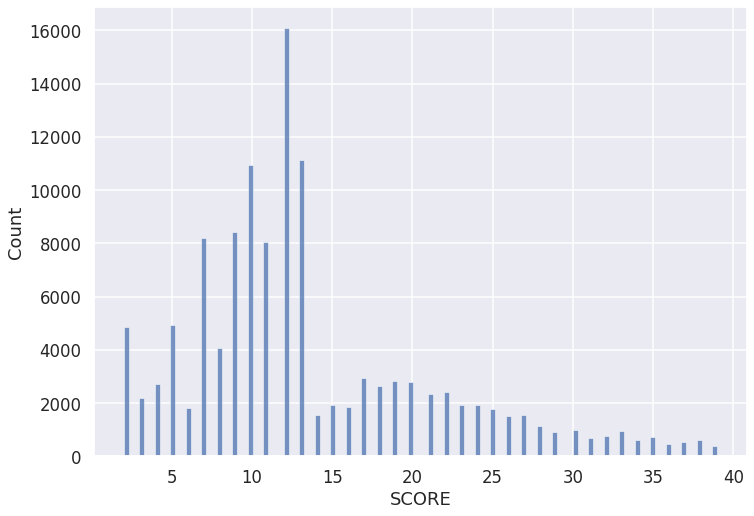

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme()
sns.set_context("talk", font_scale=1.)

# sns.set_style('ticks')
fig, ax = plt.subplots()
# the size of A4 paper
fig.set_size_inches(11.7, 8.27)


sns.histplot(establishments[establishments['SCORE'] < 40], x="SCORE", ax=ax)